# Powerfolio!

<img src="images/logo.png" width="150" title="stock_flex" align="center">

---

### Import Dependancies
Import system, data analytics, finance API, database tools, and visualization libraries

In [44]:
# System
import os
import time, sys
from pathlib import Path
from dotenv import load_dotenv
import requests
from datetime import date, datetime, timedelta
from ast import literal_eval as make_tuple

# Data analytics
import pandas as pd
import numpy as np

# Database tools
import sqlite3

# Visualization
import panel as pn
import panel.widgets as pnw
import plotly.express as px
import plotly.graph_objects as go
pn.extension('plotly')
pn.extension()
import holoviews as hv
import hvplot.pandas
import matplotlib.pyplot as plt

# Finance
import alpaca_trade_api as tradeapi
import quandl as ql
import finnhub

import warnings
warnings.filterwarnings('ignore')

---

## Data Connections
- Static Data Connections
- Dynamic Data Connections

### Static Data Connections

##### Stock Ticker Lists

In [45]:
# Get tickers within S&P500 index
sp500_tickers_path = Path('resources/sp500_tickers.csv')
sp500_tickers = pd.read_csv(sp500_tickers_path).sort_values(by="Symbol")

In [46]:
# Get fundamental data from csv
stock_fundamentals_data_path = Path("resources/fundamental_data.csv")
stock_fundamentals_df = pd.read_csv(stock_fundamentals_data_path)

### Dynamic Data Connections

#### Stock Price Data

In [47]:
# Alpaca API connector
load_dotenv("../resources/api_keys.env")

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
api = tradeapi.REST(
alpaca_api_key,
alpaca_secret_key,
api_version = "v2"
)

#### Fundamental Stock Data

In [48]:
# FinnHub API connector
load_dotenv("../resources/api_keys.env")

# Set FinnBug API key
finnhub_api_key = os.getenv("FINNHUB_API_KEY")

# Create FinnHub API object
finnhub_client = finnhub.Client(api_key=finnhub_api_key)

# Method to obtain json data from Polygon API
def finnhub_data(ticker):
    
    data = finnhub_client.company_basic_financials(ticker, "")
    data_df = pd.DataFrame(data)
    time.sleep(1)
    
    return data_df

#### Bond Data

In [49]:
# Treasury bonds
def treasury_data():
    return ql.get("USTREASURY/YIELD")

---

## Data Parsing

##### Stock Data Parsing Methods
A collection of methods for parsing S&P 500 tickers, calling Alpaca Trade API, and querying stock_prices.db database

#### Alpaca API Methods

In [50]:
# Get prices for tickers withing a given index or sector
def stock_prices_from_api(ticker_list, start_date, end_date):
    '''Returns pd.DataFrame with prices for the given tickers
    
    ...
    
    Parameters
    ----------
    tickers_df : pd.DataFrame - contains tickers for given index or sector under 
        the "Symbol" column which is the DataFrame key
    start_date : str() - string with date in following format YYYY-MM-DD
    end_date: str() - string with date in following format YYYY-MM-DD 
    
    
    Returns
    -------
    result_df : pd.DataFrame with securities price data
    '''
   
    # Get list of tickers from the tickers_df list or tickers_df DataFrame 
    tickers = ticker_list
    
    # Parse start and end dates
    start_date = pd.Timestamp(start_date, tz="America/New_York").isoformat()
    end_date = pd.Timestamp(end_date, tz="America/New_York").isoformat()
    
    # Connect to Alpaca API and get data
    """Condition handling: 
        a. Alpaca API 422 Client Error if more than 100 tickers are passed - COMPLETE
        b. Alpaca API data max row limit of 1000 - PENDING"""
    
    
    # a. Alpaca API condition handling, sending 100 tickers at a time
    # Declate a pd.DataFrame
    result_df = pd.DataFrame()
    tickers_n = 50
    
    for i in range(0, len(tickers), tickers_n):
        # Slice the ticker list into lists of 50 tickers
        sliced_tickers = tickers[i:i + tickers_n] 
        
        temp_df = api.get_barset(
        sliced_tickers,
        timeframe = "1D",
        start = start_date,
        end = end_date,
        limit = 1000).df

        # Append temporary dataframe to result_df
        result_df = pd.concat([result_df, temp_df], axis = "columns", join = "outer")
        time.sleep(0.1)
        
    return result_df

#### Local <code>stock_price.db</code> Database Methods

In [51]:
# Rebuilds database for Alpaca API stock prices if necessary
def create_stock_prices_db():
    '''This method creates a SQLite database that will store all of ticker daily prices;
    This method is created to resolve the Alpaca API request limits that can greatly slow down large data requests
    '''
    
    print("This will restore the 'stock_prices' database and delete all of stored values, are you sure? y/[n]")

    conn = sqlite3.connect('resources/stock_prices.db')
    
    
# Seed stock price database
def seed_stock_prices_database(tickers_df):
    '''Seeds stock_prices database that houses all prices for tickers within an index or sector'''

    # Get data for dates indicated
    data = stock_prices_from_api(tickers_df, "2015-01-01", "2018-01-01")
    
    # Transpose dataframe
    data = data.transpose()
    
    # Connect to databse
    conn = sqlite3.connect('resources/stock_prices.db') 
    c = conn.cursor()
    
    # Iterate over dataframe and populate the database
    for ticker, sub_frame in data.groupby(level=0):
        
        ticker = "_" + ticker.replace('.','_')
        
        list_of_tables = c.execute(f"SELECT name FROM sqlite_master WHERE type='table' AND name='{ticker}';").fetchall()
        if list_of_tables == []:
            sub_frame.transpose().to_sql(ticker, conn, if_exists='append')
        else:
            sub_frame.transpose().to_sql(ticker, conn, if_exists='append')
    
    conn.commit()
    conn.close()

    

# Update stock price database     
def update_stock_prices_database(tickers_df):
    '''Updates stock_prices database that houses all prices for tickers within an index or sector'''
    
    # Get today's date
    today_date = date.today().strftime("%Y-%m-%d")
    
    # Connect to databse
    conn = sqlite3.connect('resources/stock_prices.db') 
    c = conn.cursor()
    
    # Iterate over dataframe and populate the database
    ticker_count = 0
    for index, ticker_data in tickers_df.iterrows():
        
        ticker = "_" + ticker_data["Symbol"].replace('.','_')
        
        # Get list of all tables in databse
        list_of_tables = c.execute(f"SELECT name FROM sqlite_master WHERE type='table' AND name='{ticker}';").fetchall()
        
        # If table does not exist, create and seed
        if list_of_tables == []: # If tables does not exist
            # Get data from Alpaca API
            data = stock_prices_from_api(ticker_data, "2015-01-01", "2018-01-01")
            
            # Write stock data to databse
            data.to_sql(ticker, conn, if_exists='append')
            
        else: # If table does exist
            try:
                # Get last date from the table
                last_date = c.execute(f"SELECT time FROM {ticker} ORDER BY time DESC LIMIT 1").fetchall()
                last_date = ''.join(last_date[0]).split(" ")[0]

                # Get next date
                next_date = datetime.strptime(last_date, '%Y-%m-%d') + timedelta(days=1)

                # Change date format for Alpaca
                next_date = next_date.strftime("%Y-%m-%d")
                
                # Get today's date
                today_date = datetime.today().strftime("%Y-%m-%d")
                
                if last_date < today_date:

                    # Get data from Alpaca API
                    data = stock_prices_from_api(ticker_data, last_date, today_date)

                    # Write data to database
                    data.to_sql(ticker, conn, if_exists='append')
                
                else:
                    pass
            except:
                pass
            
        ticker_count += 1
    print(f"Processing {ticker} | {ticker_count}/{len(tickers_df.index)}")
    
    conn.commit()
    conn.close()
    
    
    
# Get stock prices from database
def stock_prices_from_db(ticker_df, start_date, end_date):
    '''Returns a pd.DataFrame with stock price data for tickers passed in ticker_df and 
    filtered by dates passed in start_date and end_date
    
    ...
    
    Parameters
    ----------
    tickers_df : pd.DataFrame - contains tickers for given index or sector under 
        the "Symbol" column which is the DataFrame key
    start_date : str() - string with date in following format YYYY-MM-DD
    end_date: str() - string with date in following format YYYY-MM-DD 
    
    
    Returns
    -------
    result_df : pd.DataFrame with securities price data
    '''
    # Connect to database
    conn = sqlite3.connect('resources/stock_prices.db') 
    c = conn.cursor()
    
    # Cast dates to pandas datetime
    start_date = pd.Timestamp(start_date, tz="America/New_York").isoformat()
    end_date = pd.Timestamp(end_date, tz="America/New_York").isoformat()
    
    # Declare result_df
    result_df = pd.DataFrame()
    
    # Iterate over tickers
    for ticker in list(ticker_df["Symbol"]):
        
        try:
            # Parse ticker name
            _ticker = "_" + ticker.replace('.','_')

            # Query databse
            data = pd.read_sql_query(f"SELECT * FROM {_ticker}", conn)

            # Filter database by dates
            data = data[(data['time'] >= start_date) & (data['time'] <= end_date)].set_index(['time'])

            # Concatenate dataframes
            result_df = pd.concat([result_df, data], axis = "columns", join = "outer")
        
        except:
            print(f"Ticker {ticker} not found in database.")
        
    conn.commit()
    conn.close()
        
    # Create a multi-index 
    ## Transpose the df
    result_df = result_df.transpose()
    
    ## Get dataframe keys
    keys = []
    for key in result_df.index:
        keys.append(make_tuple(key))

    ## Build an index
    index = pd.MultiIndex.from_tuples(keys, names=('Symbol', 'Data'))

    ## Set index
    result_df = result_df.set_index(index).transpose()
        
    return result_df


# Get database date-range
def get_db_daterange():
    
    # Connect to database
    conn = sqlite3.connect('resources/stock_prices.db') 
    c = conn.cursor()
    
    last_date = pd.read_sql_query("SELECT time FROM _MSFT ORDER BY time DESC LIMIT 1", conn)['time'][0].split(" ")[0]
    
    first_date = pd.read_sql_query("SELECT time FROM _MSFT ORDER BY time ASC LIMIT 1", conn)['time'][0].split(" ")[0]
    
    
    conn.commit()
    conn.close()
    
    return (first_date, last_date)

def offline_application_set_up():
    create_stock_prices_db()
    seed_stock_prices_database(sp500_tickers)
    update_stock_prices_database(sp500_tickers)

#### Fundamental Data Methods

In [52]:
# Get stock fundamental data from FinnHub
def generate_stock_fundamentals_from_finnhub(tickers_df):
    '''Returns pd.DataFrame with fundamentals of tickers within tickers_df
    
    ...
    Parameters
    ----------
    tickers_df : pd.DataFrame - contains tickers for given index or sector under 
        the "Symbol" column which is the DataFrame key
        
    Returns
    -------
    result_df : pd.DataFrame - securities fundamental data
    '''
    
    result_df = pd.DataFrame()
    
    
    for ticker in tickers_df['Symbol']:
        fundamental_data = finnhub_data(ticker)
        result_df = pd.concat([result_df, fundamental_data], axis='rows', join="outer")
        
        
    # Parse the dataframe
    result_df = result_df.reset_index().set_index('symbol')
    result_df = result_df.drop('metricType', 1)
    result_df.columns = ['metric_type', 'metric', 'series']
    
    return result_df




# Refresh stock fundamental data csv
def refresh_fundamentals_csv(tickers_df):
    '''Returns pd.DataFrame with fundamentals of tickers within tickers_df
    and/or calls to generate a refreashed dataset
    
    ...
    Parameters
    ----------
    tickers_df : pd.DataFrame - contains tickers for given index or sector under 
        the "Symbol" column which is the DataFrame key
    '''
    result_df = generate_stock_fundamentals_from_finnhub(tickers_df)
    result_df.to_csv("resources/fundamental_data.csv", mode='w')
    
    
    
    
    
    

# Fundamental data filter
def fundamental_data_query(tickers_df, stock_fundamentals_df, fundamental_indicator_keys):
    '''Returns a pd.DataFrame of fundamental data filtered by user input range
    
    ...
    
    Parameters
    ----------
    tickers_df : pd.DataFrame - dataframe to be processed, contains tickers
    fundamental_indicator_key : str() - keyword for fundamental indicator requested
    
        Fundamental indicator keys ->
        
        P/E Ratio : [pe_ratio]
        EPS (Earnings per Share) : [eps]
        Annual Dividend : [dividend]
        Beta (vs. S&P 500) : [beta]
        EBIDT : [ebidt]
        Quick Ratio : [quick_ratio]
        3 Year Revenue Growth : [rev_growth]
        Free Cash Flow : [cash_flow]
    
    lower_bound : int() or float() - lower bound for fundamental value filter, default = -1000000
    upper_bound : int() or float() - upper bound for fundamental value filter, default = 1000000
     
     
     
    Returns
    -------
    result_df : pd.DataFrame - dataframe with ticker and filtered fundamental data
    '''

    fund_indicators_dict = {
        'pe_ratio' : 'peNormalizedAnnual',
        'eps' : 'epsNormalizedAnnual',
        'dividend' : 'dividendsPerShareTTM',
        'beta' : 'beta',
        'ebidt' : 'ebitdPerShareTTM',
        'quick_ratio' : 'quickRatioAnnual',
        'rev_growth' : 'revenueGrowth3Y',
        'free_cash_flow' : 'freeCashFlowAnnual'   
    }

    # Declare result_df
    result_df = pd.DataFrame()
    
    # Declate tickers list
    tickers_list = tickers_df['Symbol']
    
    # Declare fundamental data df and filter by ticker df
    data_df = stock_fundamentals_df[stock_fundamentals_df.symbol.isin(tickers_list)]
    data_df = data_df.set_index(['symbol'])
    
    # Extract requested fundamental data
    for ind in fundamental_indicator_keys:
        df = data_df[data_df['metric_type'] == fund_indicators_dict[ind]]
        result_df = pd.concat([result_df, df], axis = 1, join = 'outer')
    
        # Clean up df
        result_df = result_df.drop(columns = ['metric_type', 'series'])
        result_df = result_df.rename(columns = {'symbol' : 'ticker', 
                                'metric' : ind})
        
            # Convert all df values to numeric
        result_df[ind] = result_df[ind].apply(pd.to_numeric)

    
    
    return result_df

---

## Fundamental Portfolio Methods

In [53]:
# Generate pd.DataFrame of fundamental values needed for Dashboard filtering
fundamental_values = fundamental_data_query(sp500_tickers, stock_fundamentals_df, ['eps', 'pe_ratio', 'dividend','ebidt','quick_ratio','rev_growth','free_cash_flow'])

In [54]:
# Filter stocks by Dashboard selection
def filter_stocks_by_fundamentals(pe_range: tuple, 
                                  eps_range: tuple,
                                  dividend_range: tuple):
    
    # Filter PE and EPS
    min_pe = pe_range[0]
    max_pe = pe_range[1]
    
    min_eps = eps_range[0]
    max_eps = eps_range[1]
    
    min_dividend = dividend_range[0]
    max_dividend = dividend_range[1]
    
    # Filer fundamental_values dataframe by value range
    result_df = fundamental_values[(fundamental_values['eps'] >= min_eps) & 
                                   (fundamental_values['eps'] <= max_eps) & 
                                   
                                   (fundamental_values['pe_ratio'] >= min_pe) & 
                                   (fundamental_values['pe_ratio'] <= max_pe) &
                                   
                                   (fundamental_values['dividend'] >= min_dividend) & 
                                   (fundamental_values['dividend'] <= max_dividend)
                                  ]
    
    return result_df


# List of dates between two user selected dates
def list_of_dates_between_two_dates(start_date, end_date):  
    return (pd.date_range(start_date, end_date-timedelta(days=1), freq='d').strftime("%Y-%m-%d").to_list())


# Build fundamental portfolio
def build_fundamental_portfolio(ticker_list, start_date, end_date, offline):
    
    idx = pd.IndexSlice
    stock_prices = pd.DataFrame()
    
    # Get stock prices for given stocks
    if offline == 'Enabled':
        stock_prices = stock_prices_from_db(ticker_list, start_date, end_date)
        
    elif offline == 'Disabled':
        stock_prices = stock_prices_from_api(ticker_list, start_date, end_date)

    if weighting_type == 'Equal':      
        
        result_portfolio_df = stock_prices.iloc[:, stock_prices.columns.get_level_values(1)=='close']  
        
        portfolio_return = result_portfolio_df.pct_change().dropna().sum(axis=1)
        
        portfolio_return_df = pd.DataFrame({'time' : portfolio_return.keys(), 'close' : portfolio_return.values}).set_index(['time'])
        
        
    return portfolio_return_df

# Plot built fundamental portfolio
def lineplot_fundamental_portfolio(ticker_list,
                               portfolio_weights_type,
                               portfolio_start_date,
                               portfolio_end_date,
                               offline: str()):
#     portfolio_returns
    
    portfolio_returns = build_fundamental_portfolio(ticker_list,
                                                    portfolio_weights_type,
                                                    portfolio_start_date,
                                                    portfolio_end_date,
                                                    offline)
    
    return px.line(
        portfolio_returns.reset_index(),
        x="time",
        y="close",
        title="Portfolio Returns",
        labels={
            "time" : 'Year',
            "close" : 'Portfolio Returns, %'
            })

## Data Visualization

### Dashboard Fundamental Portfolio filter methods

### Powerfolio! Dashboard

#### Heading

In [55]:
# Color palatte
background_color = "WhiteSmoke"

# Dashboard title
title_panel = pn.Row(
    pn.panel("images/logo.png", height=60),
    pn.Column("#Powerfolio!", width=1000),
    pn.Spacer(background=background_color, sizing_mode='stretch_both'),
    width_policy='max',
    sizing_mode='stretch_both',
    background=background_color)

#### Welcome to Powerfolio! Tab

In [56]:
welcome_message = "Powerfolio! is awesome"

# Loading bars
fundamental_refresh_loading_bar = pn.indicators.Progress(name='Progress', active=False, width=200, bar_color = 'primary')
offline_db_loading_bar = pn.indicators.Progress(name='Progress', active=False, width=200, bar_color = 'danger')

#####################################################################

# Refresh fundamentals button
btn_refresh_fundamental_data_descriptor = "Refreshes stock fundamental data for S&P 500 from FinnHub (API key required) <br><br> This may take 5-10 minutes"
btn_refresh_fundamental_data = pn.widgets.Button(name='Refresh Fundamentals', button_type='primary', width=200)

# Refresh fundamentals button event method
def refresh_fundamental_data_event(event):
    fundamental_refresh_loading_bar.active = True
    refresh_fundamentals_csv(sp500_tickers)
    fundamental_refresh_loading_bar.active = False
    
## Refresh fundamentals button on-click
btn_refresh_fundamental_data.on_click(refresh_fundamental_data_event)


#####################################################################

# TODO: stock prices offline mode

btn_offiline_db_descriptor = "Offline function allows user to download stock price data from Alpaca Trade API and store it on a local databse <br><br> This may take 5-10 minutes"

radio_button_offiline_db = pn.widgets.RadioButtonGroup(name='Enable Offline Mode', 
                                                     options=['Disabled', 'Enabled'], 
                                                     button_type='default')


btn_offiline_db = pn.widgets.Button(name='Refresh Stock Prices', button_type='danger', width=200)

# Refresh fundamentals button event method
def btn_offiline_db_event(event):
    if radio_button_offiline_db.value == 'Enabled':
        offline_db_loading_bar.active = True
        create_stock_prices_db()
        seed_stock_prices_database(sp500_tickers)
        update_stock_prices_database(sp500_tickers)
        offline_db_loading_bar.active = False
    
    
## Refresh fundamentals button on-click
btn_offiline_db.on_click(btn_offiline_db_event)

#####################################################################

# Welcome to Powerfolio! tabs
welcome_to_powerfolio = pn.Column(
    welcome_message,
    pn.layout.Divider(margin=(-20, 0, 0, 0)),
    
    
    pn.Column("## Refresh Fundamental Data",
              btn_refresh_fundamental_data_descriptor,
              pn.Row(btn_refresh_fundamental_data, fundamental_refresh_loading_bar),
              pn.layout.Divider(margin=(-20, 0, 0, 0))),
    
    pn.Column("## Launch Offline Mode",
              btn_offiline_db_descriptor,
              pn.Column(radio_button_offiline_db,
                        pn.Row(btn_offiline_db,offline_db_loading_bar)
                       )
             )

)

#### Fundamental Portfolio Tab

In [57]:
# Fundamental value filter
fundamental_filter_title = pn.panel("## Fundamental Stock Selector")

#####################################################################

# PE filter
## Get PE value range
min_pe_value =  round(float(fundamental_values['pe_ratio'].min()),2)
max_pe_value =  round(float(fundamental_values['pe_ratio'].max()),2)

## TextInput - input minimum and maximum PE values
text_input_min_pe_values = pn.widgets.TextInput(name='Min', max_width=70, placeholder = str(min_pe_value))
text_input_max_pe_values = pn.widgets.TextInput(name='Max', max_width=70, placeholder = str(max_pe_value))



# EPS filter
## Get EPS value range
min_eps_value = round(float(fundamental_values['eps'].min()),2)
max_eps_value = round(float(fundamental_values['eps'].max()),2)

## Text Input - input minimum and maximum EPS values
text_input_min_eps_values = pn.widgets.TextInput(name='Min', max_width=70, placeholder = str(min_eps_value))
text_input_max_eps_values = pn.widgets.TextInput(name='Min', max_width=70, placeholder = str(max_eps_value))



# Dividend filter
## Get Divident value range
min_dividend_value = round(float(fundamental_values['dividend'].min()),2)
max_dividend_value = round(float(fundamental_values['dividend'].max()),2)

## TextInput - input minimum and maximum Dividend values
text_input_min_dividend_values = pn.widgets.TextInput(name='Min', max_width=70, placeholder = str(min_dividend_value))
text_input_max_dividend_values = pn.widgets.TextInput(name='Min', max_width=70, placeholder = str(max_dividend_value))



#---------------------------------------------------------------------------------------
# Declare filtered_fundamental_stocks_df and populate with all stocks
filtered_fundamental_stocks_df = filter_stocks_by_fundamentals((min_pe_value, max_pe_value),
                                                               (min_eps_value, max_eps_value),
                                                               (min_dividend_value, max_dividend_value)
                                                              )



# Generate fundamental stock viewer DataFrame view 
fundamental_stocks_dataframe_viewer = pn.widgets.DataFrame(filtered_fundamental_stocks_df, 
                                                           name='Filtered Stocks',
                                                           sortable=True,
                                                           autosize_mode='fit_viewport',
                                                           frozen_columns=0,
                                                           height=350
                                                          )
   
#---------------------------------------------------------------------------------------
# Button - filteres stocks by user selected fundamental values
btn_update_fundamental_stocks_dataframe_viewer = pn.widgets.Button(name='Apply selection', button_type='primary')

# Refresh filtered stock results and dtaframe display
def update_fundamental_stocks_dataframe_viewer(event):
    
    pe_range_selected = tuple()
    eps_range_selected = tuple()
    dividend_range_selected = tuple()
    
    if text_input_min_pe_values.value is '' or text_input_max_pe_values.value is '':
        pe_range_selected = (min_pe_value, max_pe_value)
    else:
        pe_range_selected = (float(text_input_min_pe_values.value), 
                             float(text_input_max_pe_values.value)
                            )
    
    if text_input_min_eps_values.value is '' or text_input_max_eps_values.value is '':
        eps_range_selected = (min_eps_value, max_eps_value)
    else:
        eps_range_selected = (float(text_input_min_eps_values.value), 
                              float(text_input_max_eps_values.value)
                             )
        
    if text_input_min_dividend_values.value is '' or text_input_max_dividend_values.value is '':
        dividend_range_selected = (min_dividend_value, max_dividend_value)
    else:
        dividend_range_selected = (float(text_input_min_dividend_values.value), 
                                   float(text_input_max_dividend_values.value))
    
    fundamental_stocks_dataframe_viewer.value =  filter_stocks_by_fundamentals(pe_range_selected, eps_range_selected, dividend_range_selected)
    
## Refresh filtered stock results button
btn_update_fundamental_stocks_dataframe_viewer.on_click(update_fundamental_stocks_dataframe_viewer)


#---------------------------------------------------------------------------------------
# Reset button
# Refresh filtered stock results and dtaframe display
btn_reset_fundamental_stocks_dataframe_viewer = pn.widgets.Button(name='Reset', button_type='primary')

def reset_fundamental_stocks_dataframe_viewer(event):
    
    # reset TextInput fields
    text_input_min_pe_values.value = str(min_pe_value)
    text_input_max_pe_values.value = str(max_pe_value)
    text_input_min_eps_values.value = str(min_eps_value)
    text_input_max_eps_values.value = str(max_eps_value)
    text_input_min_dividend_values.value = str(min_dividend_value)
    text_input_max_dividend_values.value = str(max_dividend_value)

    # reset fundamental_stocks_dataframe_viewer
    fundamental_stocks_dataframe_viewer.value =  filter_stocks_by_fundamentals((min_pe_value, max_pe_value),
                                                                               (min_eps_value, max_eps_value),
                                                                               (min_dividend_value, max_dividend_value)
                                                                              )
    
## Reset fundamental_stocks_dataframe_viewer
btn_reset_fundamental_stocks_dataframe_viewer.on_click(reset_fundamental_stocks_dataframe_viewer)



#####################################################################

# Portfolio builder

# Portfolio date selector
## Generate date range for DatePicker
date_range = list_of_dates_between_two_dates(date.fromisoformat('2000-01-01'),
                                             date.fromisoformat(datetime.today().strftime("%Y-%m-%d")))

## DatePicker - selects date range for simlated portfolio
datepicker_date_start_date_selector = pn.widgets.DatePicker(name="Start Date:", enabled_dates=date_range, width=100)
datepicker_date_end_date_selector = pn.widgets.DatePicker(name="End Date:", enabled_dates=date_range, width=100)

# # Select portfolio weight types - Radio Buttons

# radio_btn_portfolio_weight_types = pn.widgets.RadioButtonGroup(name='Portfolio weight types', 
#                                                      options=['Equal', 'Money Weighted', 'PE Weighted', 'EPS Weighted', 'Dividend Weighed'], 
#                                                      button_type='default')

# Select whether to use all filtered stocks or selected stocks in portfolio
radio_btn_fundamental_portfolio_stock_selector = pn.widgets.RadioButtonGroup(name='Portfolio Stock Selection',
                                                                             options=['Select All Stocks', 'User Selected Stocks'],
                                                                             button_type='primary',
                                                                            width=100)




# Build and plot portfolio



#####################################################################


# Stock filter tab
filter_tab = pn.Column(
    fundamental_filter_title,
    pn.layout.Divider(margin=(-20, 0, 0, 0)),
    
    # Fundamental analysis selectors area
    pn.Row(
        # Criteria selection via textbox entry
        pn.Column(
            pn.panel("### Selection criteria"),
            # Gridbox with selection criteria text fields and descriptors
            pn.GridBox(
                    pn.panel("P/E - price / earnings", 
                             style={'font-weight' : 'bold'}),
                    pn.Row(text_input_min_pe_values, 
                           text_input_max_pe_values, 
                           width_policy='max'),

                    pn.panel("EPS - earnings per share", 
                             style={'font-weight' : 'bold'}),
                    pn.Row(text_input_min_eps_values, 
                           text_input_max_eps_values, 
                           width_policy='max'),

                    pn.panel("Dividend per share", 
                             style={'font-weight' : 'bold'}),
                    pn.Row(text_input_min_dividend_values, 
                           text_input_max_dividend_values, 
                           width_policy='max'),
                ncols = 2,
                width_policy='fit'
            ),
            # Button to excecute filter and reset filter functions
            pn.panel(btn_update_fundamental_stocks_dataframe_viewer),
            pn.panel(btn_reset_fundamental_stocks_dataframe_viewer),
        width_policy='fit'),

        # Display of selected stocks
        pn.Column(pn.panel("### Filtered Stocks"),
                  pn.Row(fundamental_stocks_dataframe_viewer, 
                         height = 100, 
                         sizing_mode='stretch_both'),
                  width_policy='fit'),
        
        # Portfolio builder
        pn.Column(pn.panel("### Portfolio Preview"),
                  radio_btn_fundamental_portfolio_stock_selector,
                  pn.layout.Divider(margin=(0, 0, 0, 0)),
                  pn.Row(datepicker_date_start_date_selector,
                         datepicker_date_end_date_selector),
                  width_policy='fit'),

    width_policy='fit')
)

#### Dashboard Tab Builder

Column
    [0] Row(background='WhiteSmoke', sizing_mode='stretch_both', width_policy='max')
        [0] PNG(str, height=60)
        [1] Column(width=1000)
            [0] Markdown(str)
        [2] Spacer(background='WhiteSmoke', sizing_mode='stretch_both')
    [1] Tabs
        [0] Column
            [0] Markdown(str)
            [1] Divider(margin=(-20, 0, 0, 0))
            [2] Column
                [0] Markdown(str)
                [1] Markdown(str)
                [2] Row
                    [0] Button(button_type='primary', name='Refresh Fundamentals', width=200)
                    [1] Progress(active=False, bar_color='primary', width=200)
                [3] Divider(margin=(-20, 0, 0, 0))
            [3] Column
                [0] Markdown(str)
                [1] Markdown(str)
                [2] Column
                    [0] RadioButtonGroup(name='Enable Offline Mode', options=['Disabled', 'Enabled'], value='Disabled')
                    [1] Row
                        [0] Button(button_type='danger', name='Refresh Stock Prices', width=200)
                        [1] Progress(active=False, bar_color='danger', width=200)
        [1] Column
            [0] Markdown(str)
            [1] Divider(margin=(-20, 0, 0, 0))
            [2] Row(width_policy='fit')
                [0] Column(width_policy='fit')
                    [0] Markdown(str)
                    [1] GridBox(ncols=2, width_policy='fit')
                        [0] Markdown(str, style={'font-weight': 'bold'})
                        [1] Row(width_policy='max')
                            [0] TextInput(max_width=70, name='Min', placeholder='4.76')
                            [1] TextInput(max_width=70, name='Max', placeholder='9179.49')
                        [2] Markdown(str, style={'font-weight': 'bold'})
                        [3] Row(width_policy='max')
                            [0] TextInput(max_width=70, name='Min', placeholder='-31.16')
                            [1] TextInput(max_width=70, name='Min', placeholder='230.09')
                        [4] Markdown(str, style={'font-weight': 'bold'})
                        [5] Row(width_policy='max')
                            [0] TextInput(max_width=70, name='Min', placeholder='0.0')
                            [1] TextInput(max_width=70, name='Min', placeholder='15.02')
                    [2] Button(button_type='primary', name='Apply selection')
                    [3] Button(button_type='primary', name='Reset')
                [1] Column(width_policy='fit')
                    [0] Markdown(str)
                    [1] Row(height=100, sizing_mode='stretch_both')
                        [0] DataFrame(autosize_mode='fit_viewport', frozen_columns=0, height=350, name='Filtered Stocks', value=            eps  ...)
                [2] Column(width_policy='fit')
                    [0] Markdown(str)
                    [1] RadioButtonGroup(button_type='primary', name='Portfolio Stock S..., options=['Select All Stocks', ...], value='Select All Stocks', width=100)
                    [2] Divider(margin=(0, 0, 0, 0))
                    [3] Row
                        [0] DatePicker(enabled_dates=['2000-01-01', ...], name='Start Date:', width=100)
                        [1] DatePicker(enabled_dates=['2000-01-01', ...], name='End Date:', width=100)
        [2] Markdown(str)
        [3] Markdown(str)
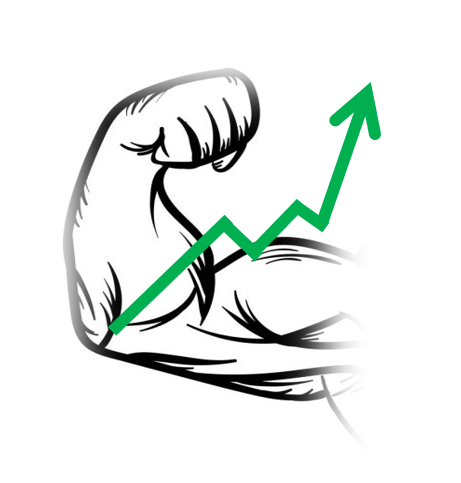

In [58]:
powerfolio_dash = pn.Column(
    pn.panel(title_panel, width=600),
    pn.Tabs(
        ("Welcome to Powerfolio!", welcome_to_powerfolio),
        ("Fundamental Portfolio", filter_tab),
        ("Technical Portfolio"),
        ("Portfolio Analysis")
    )
)



powerfolio_dash.servable()

In [59]:
text_input_min_pe_values.value


''